In [ ]:
import os
import requests
import pandas as pd
from pprint import pprint
import csv
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.linear_model import LinearRegression
import json
from math import *
from sklearn.metrics import *
import seaborn as sns

## 1. Exploraration des données
#### Objectif:
- Comprendre le mieux les données issues de l'API
- Faire une première comparaison avec le capteur de référence
#### Checklist de base
- **variable target**: les mesures 
- **lignes et colonnes**: (33497, 12) pour des données entre "2021-01-01"-->"2022-01-01"
- **type de variables**: qualitatives: 4, quantitatives: 8
- **analyse des valeurs manquantes**: pas de NaN
- **visualisation de la target**: les valeurs des mesures sont équilibrées en effet, il y a 4 mesures et chacune a 25% des valeurs dans le dataset
- **relation entre variables/target**: 

In [ ]:
path = os.getcwd()
key = 'https://api.atmo-aura.fr/api/v1/'
api_token='fb0d9e1ded2c253ba5be4726799333df'

La bibliothèque request sert à envoyer des requêtes HTTP avec Python

In [ ]:
def check_date_format(date_str):
    try:
        # Convertir la chaîne de caractères en objet datetime
        date_obj = datetime.strptime(date_str, "%Y-%m-%d")
        return True
    except ValueError:
        return False

In [ ]:
def get_site_id(key,api_token,num_departement,pm):
    """
    _Cette fonction permet de récupérer les sites mesurant le pm specifié, par département_

    Args:
        key (_str_): _Chemin commun pour accéder à l'url_
        api_token (_str_): _clés d'accées à l'api_
        num_departement (_str_): _Numéro du département_
        pm (_str_): _type de polluant (PM10 ou PM2.5)_
    Returns:
        _liste_: _liste des sites de mesure par département_
    """
    label_court_polluant = ['PM10','PM2.5']
    if not(isinstance(num_departement, str)) or (len(num_departement) != 2):
        print("Veuillez entrer le bon numéro de département")
        return None
    if (pm not in label_court_polluant):
        print("Veuillez choisir PM10 ou PM2.5")
        return None
   
    site_id = []
    url = f'{key}sites?api_token={api_token}&departements={num_departement}&label_court_polluant={pm}&en_service=1'
    
    headers = {'Accept': 'application/json', 'Authorization': f'Bearer {api_token}'}
    response = requests.get(url, headers=headers)
    response_json = response.json()
    if 'data' not in response_json:
        return None
    csv_data = response_json['data']
    if not csv_data:
        return None
    
    for i in range((len(csv_data))):
        site_id.append(csv_data[i]['id'])
    return site_id

In [ ]:
def get_mesure_id(key,api_token,site_id,pm,num_departement):
    """
    _Cette fonction permet de récupérer les mesures du pm specifié, par département et par site_

    Args:
        key (_str_): _Chemin commun pour accéder à l'url_
        api_token (_str_): _clés d'accées à l'api_
        site_id (_str_): _id su site_
        pm (_str_): _type de polluant (PM10 ou PM2.5)_
        num_departement (_str_): _Numéro du département_
        
    Returns:
        _DataFrame_: Un dataFrame contenant les informations de chaque mesure sur le site _
    """
    
    label_court_polluant = ['PM10','PM2.5']
    site_id_departement = get_site_id(key,api_token,num_departement,pm)
    if (pm not in label_court_polluant):
        return None

    if (site_id not in site_id_departement):
        return None
    
    if not(isinstance(num_departement, str)) or (len(num_departement) != 2):
        return None
    
    liste_mesure = []
    coordonnees = []
    label_site = []
    
    mesures_id = {}
    url = f'{key}mesures?api_token={api_token}&sites={site_id}&label_court_polluant={pm}&en_service=1'
    headers = {'Accept': 'application/json', 'Authorization': f'Bearer {api_token}'}
    response = requests.get(url, headers=headers)
    response_json = response.json()
    if 'data' not in response_json:
        return None
    csv_data = response_json['data']
    if not csv_data:
        return None
    
    for i in range((len(csv_data))):
        liste_mesure.append(csv_data[i]['id'])
        geojson = json.loads(csv_data[i]['geojson'])
        coordonnees.append(geojson['coordinates'])
        label_site.append(csv_data[i]['label_site'])
    mesures_id['mesure'] = liste_mesure
    mesures_id['coord'] = coordonnees
    mesures_id['label_site'] = label_site
    data = pd.DataFrame(data=mesures_id)
    return data

In [ ]:
def get_csv(key, valeur, path, api_token, pm, date_debut, date_fin,num_departement,site_id,period=5):
    """
    Cette fonction permet d'abord de vérifier si le site est bien dans le départemnt num
    et puis de récupérer un tableau de mesures de pm dans le site situé dans la commune pour une période d'une année
    Args:
        key (_str_): _Chemin commun pour accéder à l'url_
        valeur (_str_): _type des valeurs de mesure_
        path (_fichier_): _fichier où on va mettre le fichier csv_
        api_token (_str_): _clés d'accées à l'api_
        pm (_str_): _type de polluant (PM10 ou PM2.5) _
        date_debut (_date_): _date de début de mesure_
        date_fin (_date_): _date de fin de mesure_
        num_departement (_str_): _Numéro du département_
        site_id (_str_): _id du site de mesure_

    Returns:
        _tableau csv contenant des mesure horaires du polluant pm à partir de la date de début jusqu'à la date de fin_
    """
    valeurs = ['horaire','journaliere','mensuelle','annuelle']
    label_court_polluant = ['PM10','PM2.5']
    site_id_departement = get_site_id(key,api_token,num_departement,pm)
    
    mesures_id = get_mesure_id(key,api_token,site_id,pm,num_departement)
    
    ourdata_year = []
    
    if not(isinstance(num_departement, str)) or (len(num_departement) != 2):
        return None
    if (valeur not in valeurs): 
        return None
    if (pm not in label_court_polluant):
        return None
    if (not check_date_format(date_debut)) or (not check_date_format(date_fin)):
        return None
    if (site_id not in site_id_departement):
        return None
    
    dates = pd.date_range(start=date_debut, end=date_fin,periods=period)
    list_months = [str(dates[i])[:10] for i in range(len(list(dates)))]
    
    current_month_start_id = 0
    current_month_end_id = 1
    
    while (current_month_end_id <= len(list_months)-1):
        url = f"{key}valeurs/{valeur}?api_token={api_token}&valeur_brute=1&sites={site_id}&date_debut={list_months[current_month_start_id]}&date_fin={list_months[current_month_end_id]}&label_court_polluant={pm}"
        headers = {'Accept': 'application/json', 'Authorization': f'Bearer {api_token}'}
    
        response = requests.get(url, headers=headers)
        response_json = response.json()

        if 'data' not in response_json:
            return None

        csv_data = response_json['data']
        if not csv_data:
            return None

        csvheader = list(csv_data[0].keys())
        ourdata = []

        for x in csv_data:
            listing = [x[k] for k in csvheader]
            ourdata.append(listing)
        
        ourdata_year.append(ourdata[:-4])
        current_month_start_id+=1
        current_month_end_id+=1
    # print(ourdata_year)
    csv_file_name = f'{path}\\site_{site_id}{date_debut}--{date_fin}_{valeur}_{pm}_data.csv'
    with open(csv_file_name, 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(csvheader)
        for data in ourdata_year:
            writer.writerows(data)

    data = pd.read_csv(csv_file_name, delimiter=',')
    return data

In [ ]:
def none_sites(key,valeur,path,api_token,date_debut,date_fin,num_departement):
    """_Retourne pour chaque polluant les sites et les appareils sur ces sites qui n'ont pas de données sur ce polluant _

    Args:
        key (_str_): _Chemin commun pour accéder à l'url_
        valeur (_str_): _type des valeurs de mesure_
        path (_fichier_): _fichier où on va mettre le fichier csv_
        api_token (_str_): _clés d'accées à l'api_
        date_debut (_date_): _date de début de mesure_
        date_fin (_date_): _date de fin de mesure_
        num_departement (_str_): _Numéro du département_
        site_id (_str_): _id du site de mesure_

    Returns:
        _type_: _dictionnaire avec le polluant comme clés et les site comme valeurs_
    """
    PM = ['PM10','PM2.5']
    dict_none = {}
    for pm in PM:
        departement_sites_id = get_site_id(key,api_token,num_departement,pm)
        dict = {}
        for id in departement_sites_id:
            site_mesure_id = get_mesure_id(key,api_token,id,pm,num_departement)
            data_hourly = get_csv(key,valeur,path,api_token,pm,date_debut,date_fin,num_departement,id)
            if data_hourly is None:
                dict[id] = site_mesure_id
        dict_none[pm] = dict
    return dict_none

In [ ]:
def distance_between_2_measures(pt1,pt2):
    """_summary_
    
    Args:
        pt1 (_list_): _les coordonnées du premier point de mesure_
        pt2 (_list_): _les coordonnées du deuxième point de mesure_

    Returns:
        _float_: _Distance entre deux point de mesures_
    """
    R = 6373.0
    dlon = pt2[0] - pt1[0]
    dlat = pt2[1] - pt1[1]
    a = (sin(dlat/2))**2 + cos(pt1[1]) * cos(pt2[1]) * (sin(dlon/2))**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

In [ ]:
def get_distance(key,api_token,site_id,pm,num_departement):
    """_summary_
    Args:
        key (_str_): _Chemin commun pour accéder à l'url_
        api_token (_str_): _clés d'accées à l'api_
        site_id (_str_): _id su site_
        pm (_str_): _type de polluant (PM10 ou PM2.5)_
        num_departement (_str_): _Numéro du département_
    Returns:
        _DataFrame_: _Un tableau ayant pour chaque point sa distance avec les autres points de mesure du même site_
    """
    site = get_mesure_id(key, api_token,site_id,pm,num_departement)
    dict = {'Distance':site['mesure']}
    i = 0
    while i<len(site['mesure']):
        distance = []
        for k in range(len(site['mesure'])):
            dist = distance_between_2_measures(site[site['mesure']==site['mesure'][i]]['coord'].values[0],site[site['mesure']==site['mesure'][k]]['coord'].values[0])
            distance.append(dist)
        dict[site['mesure'][i]] = dist
        i=i+1
    df = pd.DataFrame(data=dict)
    return(df)

In [ ]:
# Déterminer le nombre de mesures par site
site = get_mesure_id(key,api_token,'FR15043','PM2.5','38')

data = get_csv(key,'horaire', path, api_token,'PM2.5','2021-01-01','2022-01-01','38','FR15043')

# Elimination des colonnes inutiles
data = data.drop(['validation','id_poll_ue','label_court_unite','unite'],axis=1)

# Rendre la colonne date en format datetime
data['date'] = pd.to_datetime(data['date'].str[0:10] + ' ' + data['date'].str[11:-1])


encoder = LabelEncoder()
data['code'] = encoder.fit_transform(data['mesure_id'])


* Analyse de fond

In [ ]:
sns.heatmap(data.isna())
(data.isna().sum()/data.shape[0]).sort_values(ascending=True)
# Voir les données manquantes

* Visualisation

In [ ]:
data['mesure_id'].value_counts(normalize=True)
# Voir si les données sonr équilibrées
# data['mesure_id'].value_counts().plot.pie()

In [ ]:
# Variables quantitatives
for col in data.select_dtypes('object'):
    print(f'{col :-<40} {data[col].unique()}')

In [ ]:
data = data.drop(['site_id','label_polluant','label_court_polluant','label_unite','site_label','code_polluant'],axis=1)

In [ ]:
reference = data.loc[data['type_appareil_label']=='Analyseur Air']
for mesure in data['mesure_id'].unique():
    if data.loc[data['mesure_id']==mesure,'type_appareil_label'].iloc[0] == 'Analyseur Air':
        continue
    plt.figure()
    sns.distplot(data.loc[data['mesure_id']==mesure,'valeur'],label=mesure)
    sns.distplot(reference['valeur'],label='reference')
    plt.legend()

In [ ]:
# Variables quantitatives
for col in data.select_dtypes('float'):
    plt.figure
    sns.distplot(data[col])

In [101]:
def get_new_merged(data,id):
    reference = data.loc[data['type_appareil_label']==11,['date', 'valeur','type_appareil_label','code']]
    microcapteur = data.loc[data['mesure_id']==id,['date', 'valeur','type_appareil_label','code']]
    merged = pd.merge(reference, microcapteur, on='date', how='inner', suffixes=('reference', f'_{id}'))
    return merged

In [ ]:
def get_merged(data):
    dfs = [] # liste des dataframe
    reference_index = None
    for i, mesure in enumerate(data['mesure_id'].unique()):
        if mesure[-2:] == '11':
            reference_index = i
        microcapteur = data.loc[data['mesure_id'] == mesure, ['date', 'valeur','type_appareil_label','code']]
        dfs.append(microcapteur)
    
    if reference_index is not None:
        reference = dfs.pop(reference_index)
        dfs.insert(0, reference)
    
    merged = dfs[0]
    for i in range(1, len(dfs)):
        code = dfs[i]['code'].unique()[0]
        merged = pd.merge(merged, dfs[i], on='date', how='inner', suffixes=('', f'_{code}'))
    return merged

In [ ]:
def get_metrics_per_week(data,seuil=0.9,freq='W'):
    """
    Cette fonction permet d'avoir le coefficient de détermination par semaine pour chaque microcapteur avec le capteur de référence 
    Args:
        data (DataFrame): les données de tous les microcapteurs dans le même site

    Returns:
        DataFrame: DataFrame contenant les coefficients de détermination par semaine pour chaque microcapteur
    """
    # encoder = LabelEncoder()
    # data['code'] = encoder.fit_transform(data['mesure_id'])
    merge_data = get_merged(data)
    weeks = [g for n, g in merge_data.set_index('date').groupby(pd.Grouper(freq='W'))]
    dictio = {'semaine':[],'mesure_id':[],'type appareil':[],'r2':[],'MAE':[],'MAE_predicted':[],'RMSE':[]}

    for i, week_data in enumerate(weeks, start=1):
        if len(week_data) >= 7*24*seuil:
            semaine = i
            for code in data['code'].unique():
                Y = week_data['valeur'].values.reshape(-1, 1)
                if code == 0:
                    continue
                type_appareil = data.loc[data['code'] == code, 'type_appareil_label'].iloc[0]
                mesure_id = data.loc[data['code'] == code, 'mesure_id'].iloc[0]
                X = week_data[f'valeur_{code}'].values.reshape(-1, 1)
                model = LinearRegression()
                model.fit(X, Y)
                deter = model.score(X, Y)
                Z = model.predict(X)
                error = median_absolute_error(Y,Z)
                error_predicted = mean_absolute_error(Y,Z)
                error_squared = mean_squared_error(Y,Z)
                dictio['semaine'].append(semaine)
                dictio['mesure_id'].append(mesure_id)
                dictio['type appareil'].append(type_appareil)
                dictio['r2'].append(deter)
                dictio['MAE'].append(error)
                dictio['MAE_predicted'].append(error_predicted)
                dictio['RMSE'].append(np.sqrt(error_squared))
    df = pd.DataFrame(data=dictio)
    return df

In [95]:
merged = get_new_merged(data,'15043_39_57_3')
data_completeness = []
weeks = [g for n, g in merged.set_index('date').groupby(pd.Grouper(freq='W'))]
for week in weeks:
    data_completeness.append((len(week)/(24*7))*100)
data_restant = np.mean(data_completeness)
pourcentage_format = "{:.2f}".format(data_restant)
print(f'Quand on regrouppe les données par semaine, on a {pourcentage_format}% de data qui restent.')

Quand on regrouppe les données par semaine, on a 90.30% de data qui restent.


In [104]:
merged = get_new_merged(data,'FR15043_39_57_4')
merged

,valeurreference,type_appareil_labelreference,codereference,date,valeur_FR15043_39_57_4,type_appareil_label_FR15043_39_57_4,code_FR15043_39_57_4


In [107]:
df = get_metrics_per_week(data,seuil=0.9) 


In [106]:
df

,semaine,mesure_id,type appareil,r2,MAE,MAE_predicted,RMSE
0,2,FR15043_39_57_5,Microcapteur (site fixe),0.959602,0.854567,1.082735,1.410087
1,2,FR15043_39_57_4,Microcapteur (site fixe),0.953741,0.940792,1.150377,1.508925
2,2,FR15043_39_57_3,Microcapteur (site fixe),0.941611,1.312455,1.393952,1.695253
3,3,FR15043_39_57_5,Microcapteur (site fixe),0.915564,2.459607,2.394560,2.795327
4,3,FR15043_39_57_4,Microcapteur (site fixe),0.914895,2.427971,2.387349,2.806370
5,3,FR15043_39_57_3,Microcapteur (site fixe),0.923357,2.120409,2.258479,2.663208
6,4,FR15043_39_57_5,Microcapteur (site fixe),0.982745,0.502334,0.651850,0.875148
7,4,FR15043_39_57_4,Microcapteur (site fixe),0.984217,0.486903,0.604459,0.837007
8,4,FR15043_39_57_3,Microcapteur (site fixe),0.975389,0.559725,0.773148,1.045192
9,5,FR15043_39_57_5,Microcapteur (site fixe),0.955959,0.862356,1.014147,1.248730


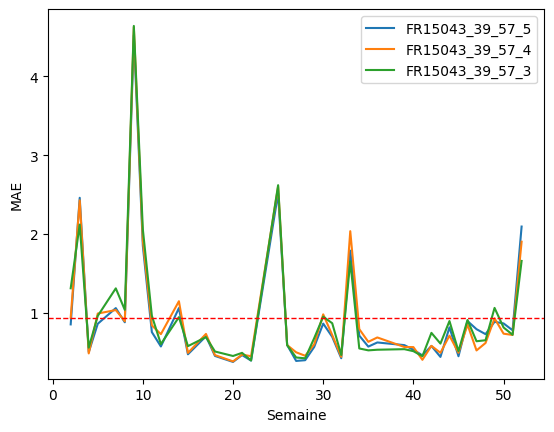

In [96]:
for mesure in df['mesure_id'].unique():
    plt.plot(df.loc[df['mesure_id']==mesure , 'semaine'],df.loc[df['mesure_id']==mesure , 'MAE'],label=mesure)
    # plt.axhline(y=df.loc[df['mesure_id']==mesure , 'MAE'].mean(),c='r',ls='--',lw=1,label=)
plt.axhline(y=df['MAE'].mean(),c='r',ls='--',lw=1)
plt.xlabel('Semaine')
plt.ylabel('MAE')
plt.legend()

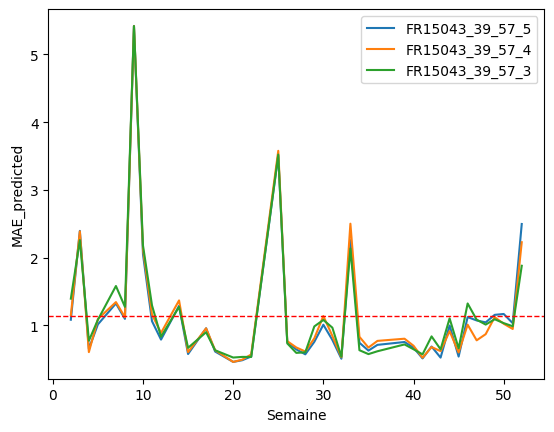

In [108]:
for mesure in df['mesure_id'].unique():
    plt.plot(df.loc[df['mesure_id']==mesure , 'semaine'],df.loc[df['mesure_id']==mesure , 'MAE_predicted'],label=mesure)
    # plt.axhline(y=df.loc[df['mesure_id']==mesure , 'MAE'].mean(),c='r',ls='--',lw=1,label=)
plt.axhline(y=df['MAE_predicted'].mean(),c='r',ls='--',lw=1)
plt.xlabel('Semaine')
plt.ylabel('MAE_predicted')
plt.legend()

In [ ]:
for mesure in df['mesure_id'].unique():
    plt.plot(df.loc[df['mesure_id']==mesure , 'semaine'],df.loc[df['mesure_id']==mesure , 'RMSE'],label=mesure)
    # plt.axhline(y=df.loc[df['mesure_id']==mesure , 'MAE'].mean(),c='r',ls='--',lw=1,label=)
plt.axhline(y=df['RMSE'].mean(),c='r',ls='--',lw=1)
plt.xlabel('Semaine')
plt.ylabel('RMSE')
plt.legend()

In [ ]:
for mesure in df['mesure_id'].unique():
    plt.plot(df.loc[df['mesure_id']==mesure , 'semaine'],df.loc[df['mesure_id']==mesure , 'r2'],label=mesure)
plt.axhline(y=0.7,c='r',ls='--',lw=1)
plt.axhline(y=0.5,c='r',ls='--',lw=1)
plt.xlabel('Semaine')
plt.ylabel('r2')
plt.legend()

avec l'addition des autres capteurs

In [109]:
data_new = get_csv(key,'horaire', path, api_token,'PM2.5','2023-01-01','2024-02-23','38','FR15043',period=10)
data_new = data_new.drop(['validation','id_poll_ue','label_court_unite','unite'],axis=1)
data_new['date'] = pd.to_datetime(data_new['date'].str[0:10] + ' ' + data_new['date'].str[11:-1])
encoder = LabelEncoder()
data_new['code'] = encoder.fit_transform(data_new['mesure_id'])


In [ ]:
merged_new = get_merged(data_new)
data_completeness = []
weeks = [g for n, g in merged_new.set_index('date').groupby(pd.Grouper(freq='W'))]
for week in weeks:
    data_completeness.append((len(week)/(24*7))*100)
data_restant = np.mean(data_completeness)
pourcentage_format = "{:.2f}".format(data_restant)
print(f'Quand on regrouppe les données par semaine, on a {pourcentage_format}% de data qui restent.')

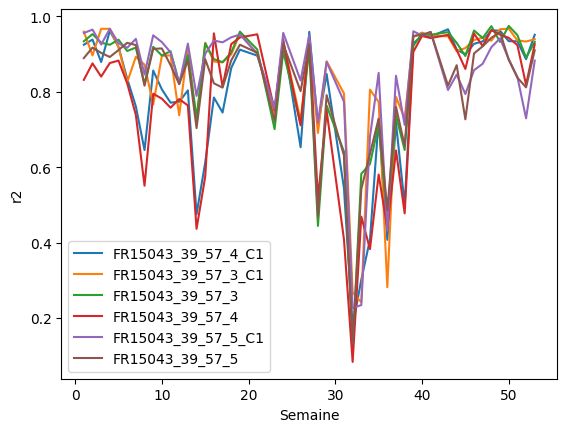

In [110]:
df_new = get_metrics_per_week(data_new,seuil=0.9)
for mesure in df_new['mesure_id'].unique():
    plt.plot(df_new.loc[df_new['mesure_id']==mesure , 'semaine'],df_new.loc[df_new['mesure_id']==mesure , 'r2'],label=mesure)
# plt.axhline(y=0.7,c='r',ls='--',lw=1)
# plt.axhline(y=0.5,c='r',ls='--',lw=1)
plt.xlabel('Semaine')
plt.ylabel('r2')
plt.legend()